# Sample Notebook: Exploring an Image Dataset

The script *extract_info_from_dataset.py* extracts information from a dataset of letter images and saves the extracted information in a csv file. This notebook demonstrates how the information can be used to explore the dataset and retrieve letter images satistfying given criteria such as the date it was written, the recipient of the letter, or its signator. Along with the *letter_image* class, the information can also be used to find letters similar to a letter image not in the dataset.

In [1]:
import pandas as pd
import letter_image as li
import os
import nltk.tag.stanford as st
from ast import literal_eval

dataset_dir = "/media/datadr/datasets/letters" 


## Get the Dataset Data  from the CSV File

In [2]:
# Read the data frame fromt he csv file
data_file_name= "infoTable.csv"
data = pd.read_csv(data_file_name)

### The data table: a closer look

Each row in the data frame represents a semantic segment or part of the image whose name is **image_name**.
The data frame consists of:
    -  an image_name column 
    -  a dir column giving the path to teh image
    -  a part column which contains the name of the current part. Currently this is one of: 
        -  heading/sender 
        -  recipient
        -  greeting
        -  body
        -  signature
        -  date
        -  enclosures/notes
    -  a contour column which is a list of contours each representing a block of the current part. 
    -  a text column which is a list representing the OCR recognized text within the contours in contour.

In [3]:
data.head()

,image_name,dir,contour,part,text
0,letter_1135,/media/datadr/datasets/letters,"[array([[ 395. , 1417.66887443],\n ...",heading,['HILL\n\nW\n\nlﬂcﬂlPCIATID 1.7!\n\nO\nQ\nC\nO...
1,letter_1135,/media/datadr/datasets/letters,"[array([[928. , 578.84663755],\n ...",date,['2013']
2,letter_1135,/media/datadr/datasets/letters,"[array([[938. , 438.44451491],\n ...",recipient,"['April', 'M.Sc.', 'Elliott Bay', 'Mr.', 'Kids..."
3,letter_1135,/media/datadr/datasets/letters,"[array([[1389. , 483.4266401 ],\n ...",greeting,['Dear']
4,letter_1135,/media/datadr/datasets/letters,"[array([[1500. , 1560.20216494],\n ...",body,"['Hill', 'Chamber', 'Richmond', 'you on receiv..."


#### What letter parts are in the table?

In [4]:
# Letter parts
data.part.unique()

array(['heading', 'date', 'recipient', 'greeting', 'body', 'signature',
       'enclosures', nan, 'subject'], dtype=object)

#### Show a sample of the letters' dates 

In [5]:
# Dates in database
data[data.part=='date'].text.head()

1                   ['2013']
7       ['November 8. 2007']
11     ['September 1, 2018']
24        ['March 10, 2016']
76    ['September 18, 2002']
Name: text, dtype: object

#### Do we have letters in the database signed by a given signator?

In [6]:
# Do we have letters in the database signed by a given signator?
given_signator = "Joan Lau"

stanfordNER_path = "/home/reem/tools/stanford-ner-2018-10-16/"
english_nertagger = st.StanfordNERTagger(os.path.join(stanfordNER_path,\
                              "classifiers/english.all.3class.distsim.crf.ser.gz"), \
                              os.path.join(stanfordNER_path,\
                                           "stanford-ner.jar"))

letters = []
letters_w_sig = data[data.part=='signature']
for i, row in letters_w_sig.iterrows():
    for i,line in enumerate(literal_eval(row.text)):
        for inline in line.split("\n"):
            tagged=  english_nertagger.tag(inline.split())
            if ('PERSON' in [tagged[i][1] for i,tup in enumerate(tagged)]):
                if given_signator.lower() == inline.lower():
                    letters.append(i)
                
if (len(letters)> 0):
    print("Letters signed by {}:".format(given_signator))
    for i in letters:
        print(data.iloc[i].image_name)
else:
    print("No letters in the database were signed by{}:".format(given_signator))

Letters signed by Joan Lau:
letter_1135


Let us have a look at this letter...

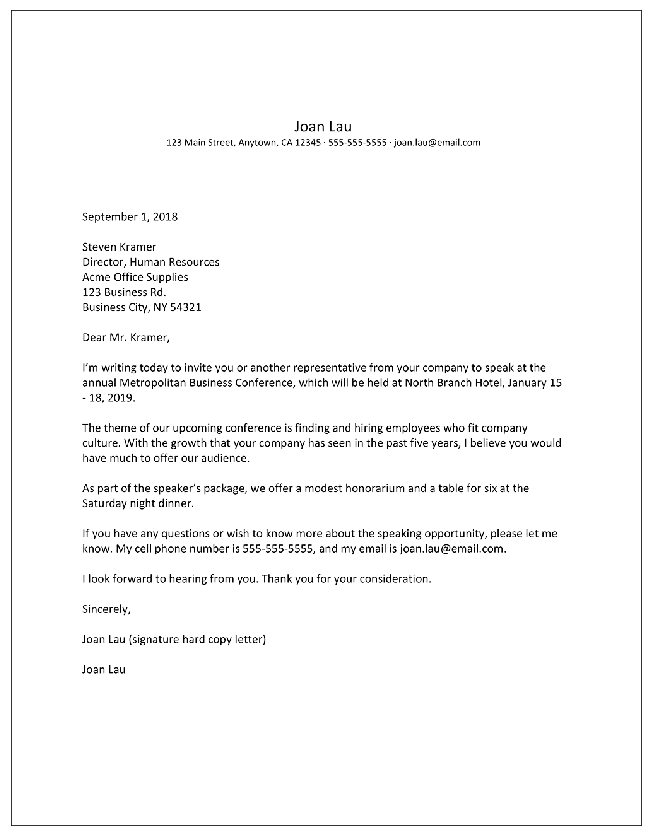

In [7]:
from skimage.io import imread
import matplotlib.pyplot as plt

letter_img = imread(os.path.join(data.loc[13].dir, data.loc[13].image_name))
fig, ax=plt.subplots(figsize=(15,15))
ax.imshow(letter_img, cmap='Greys_r')
plt.tick_params(
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                right=False,
                labeltop=False,
                labelleft=False,
                labelright=False,
                labelbottom=False) # labels along the bottom edge are off
plt.show()

### Retrieving letters that are similar to a new letter image

Sometimes we may wish to find dataset letters that are similar to a letter not in our dataset. In this case we start by extracting information from the new letter using the *letter_image* class. We can then compare the contents of the new letter to those in the dataset to, for example, find all letters signed by the same signator, or all dataset letters written on the same day as the new letter.

(Note: For more examples on how to use the letter_image class please refer to the __[letter_image_examples.ipynb](https://github.com/ReemHal/letter_images/blob/master/letter_image_examples.ipynb)__ notebook)


In [8]:
#Let's try to match our dataset letters to an new letter image
image_name = "test_letter"
letter_obj = li.letter_image("", image_name)
letter_obj.process_letter()

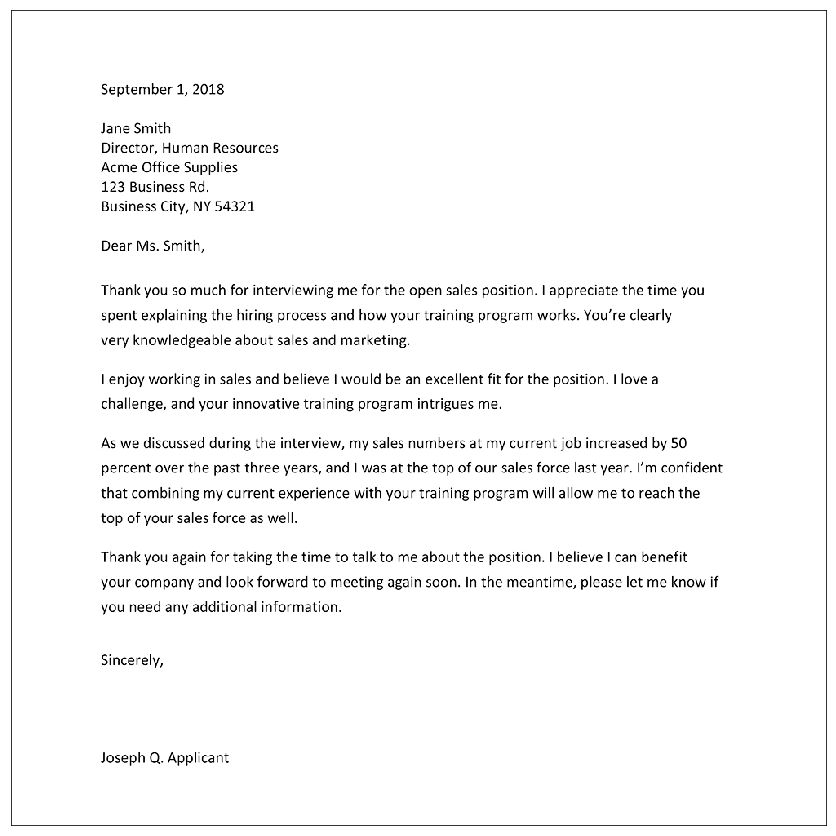

In [9]:
letter_obj.display_letter()

#### Letter Parts

First let us have a look at the parts identified within test_letter

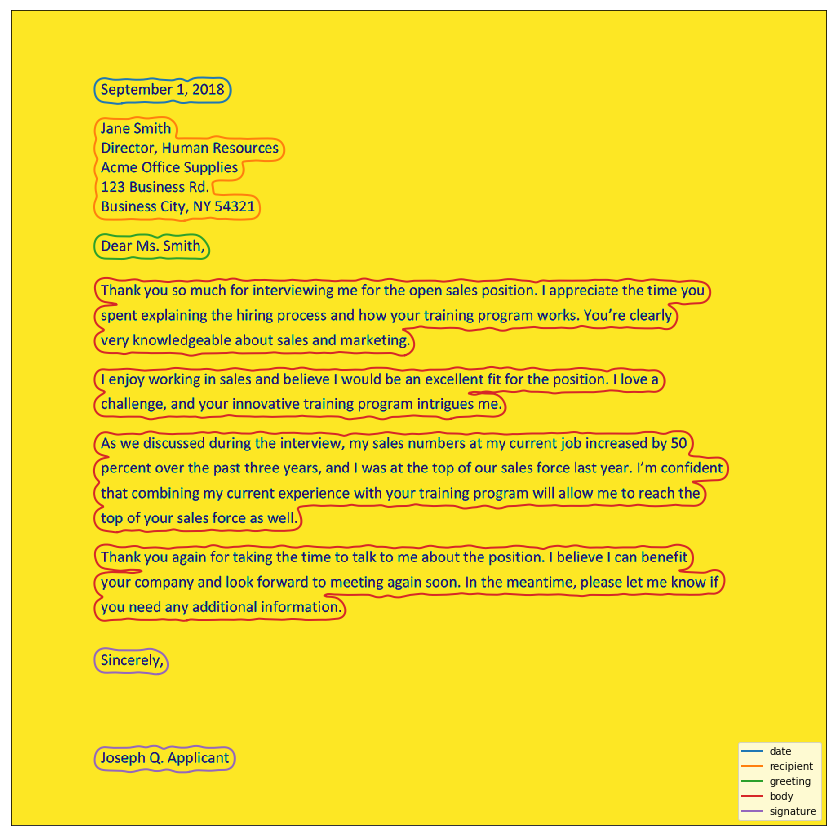

In [10]:
letter_obj.display_contours(display=True,save=False,savedir='contours')

#### Text within each part

Now let us have a look at the contents of each of those parts..

In [11]:
# What do we know about the test letter's content?
test_letter_content={}
for i,clip_item in enumerate(letter_obj.clip):
    test_letter_content[clip_item['part']] = clip_item['text']
    
for key in test_letter_content.keys():
    text = str.join("\n",[text for i,text in enumerate(test_letter_content[key])])
    print("<<{}>>\n{}\n=====".format(key, text))

<<greeting>>
Dear Ms. Smith,
=====
<<signature>>
Sincerely,
Joseph Q. Applicant
=====
<<recipient>>
Jane Smith

Director, Human Resources
Acme Ofﬁce Supplies

123 Business Rd.

Business City, NV 54321
=====
<<date>>
September 1, 2018
=====
<<body>>
Thank you so much for interviewing me for the open saies position. I appreciate the time you
spem explaining the hiring process and how your training program works. Vou’re ciearly
very knowledgeable about sales and marketing.
I enjoy working in sales and believe I would be an excellent fit for the position. I love a
challenge, and your innovative training program intrigues me.
As we discussed during the interview, my sales numbers at my current job increased by 50
percent over the past three years, and i was at the top of our sales force last year. I’m confident
that combining my current experience with yourtraining program will allow me to reach the

top of your sales force as well.
Thank you again for taking the time to talk to me about th

#### Who signed our *test_letter*?

In [12]:
#Who signed the test letter?

stanfordNER_path = "/home/reem/tools/stanford-ner-2018-10-16/"
english_nertagger = st.StanfordNERTagger(os.path.join(stanfordNER_path,\
                              "classifiers/english.all.3class.distsim.crf.ser.gz"), \
                              os.path.join(stanfordNER_path,\
                                           "stanford-ner.jar"))

sig_segment = test_letter_content['signature']
for i,line in enumerate(sig_segment):
    tagged=  english_nertagger.tag(line.split())
    if ('PERSON' in [tagged[i][1] for i,tup in enumerate(tagged)]):
        signator = line

print("Letter signed by ", signator)

Letter signed by  Joseph Q. Applicant


#### Who is the recipient of the letter?

In [13]:
# Who was the test letter sent to?
sig_segment = test_letter_content['recipient']
for i,line in enumerate(sig_segment):
    for inline in line.split("\n"):
        tagged=  english_nertagger.tag(inline.split())
        if ('PERSON' in [tagged[i][1] for i,tup in enumerate(tagged)]):
            recipient_name = inline

print("Letter was sent to ", recipient_name)

Letter was sent to  Jane Smith


### Putting things together: find similar letters in our dataset

#### Retrieve letters written on the same date

Now we would like to find all dataset letters that were written on the same data as the *test_letter*

In [14]:
#Which letters were sent on the same day as the test letter?
options= data[data.part=='date']
for i, row in options.iterrows():
    if (test_letter_content['date'][0] in  row['text']):
        print(i,":",row['image_name'])

11 : letter_0_7
97 : letter_0_4
354 : letter_1131
447 : letter_0_6
523 : letter_149


Let us look at one of those letters...

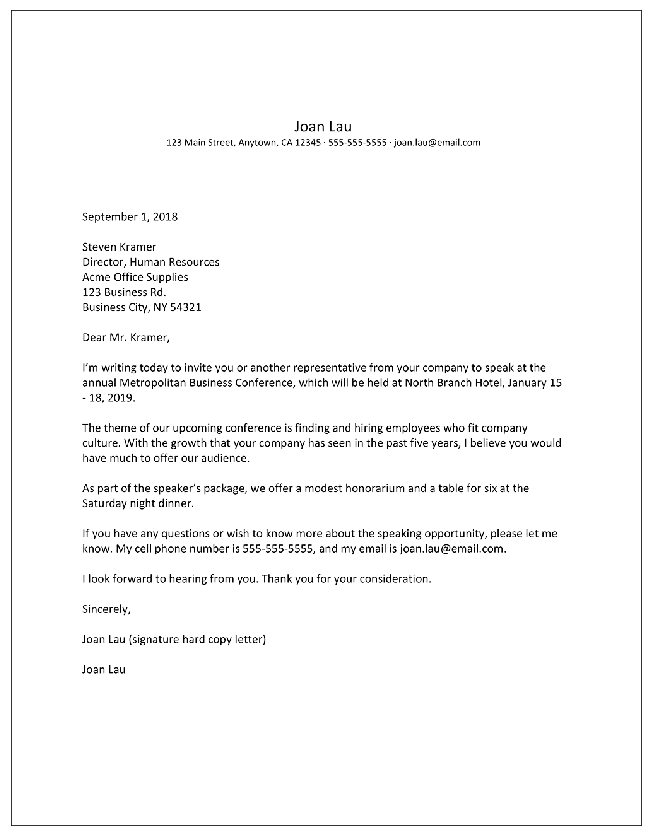

In [15]:
from skimage.io import imread
import matplotlib.pyplot as plt

letter_img = imread(os.path.join(data.loc[13].dir, data.loc[13].image_name))
fig, ax=plt.subplots(figsize=(15,15))
ax.imshow(letter_img, cmap='Greys_r')
plt.tick_params(
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                right=False,
                labeltop=False,
                labelleft=False,
                labelright=False,
                labelbottom=False) # labels along the bottom edge are off
plt.show()

#### Were any letters in our database  sent to the same recipient as the test letter?

In [16]:
# Do we have letters in the database that were sent to the same recipient?
letters = []
letters_w_sig = data[data.part=='recipient']
for i, row in letters_w_sig.iterrows():
    for i,line in enumerate(literal_eval(row.text)):
        for inline in line.split("\n"):
            tagged=  english_nertagger.tag(inline.split())
            if ('PERSON' in [tagged[i][1] for i,tup in enumerate(tagged)]):
                if recipient_name == inline.lower():
                    letters.append(i)
                
if (len(letters)> 0):
    print("Letters sent to{}:".format(recipient_name))
    for i in letters:
        print(data.iloc[i].image_name)
else:
    print("No letters in the database were sent to {}".format(recipient_name))
    

No letters in the database were sent to Jane Smith


In [18]:
print("test letter body:\n", test_letter_content['body'])

test letter body:
 ['Thank you so much for interviewing me for the open saies position. I appreciate the time you\nspem explaining the hiring process and how your training program works. Vou’re ciearly\nvery knowledgeable about sales and marketing.', 'I enjoy working in sales and believe I would be an excellent fit for the position. I love a\nchallenge, and your innovative training program intrigues me.', 'As we discussed during the interview, my sales numbers at my current job increased by 50\npercent over the past three years, and i was at the top of our sales force last year. I’m confident\nthat combining my current experience with yourtraining program will allow me to reach the\n\ntop of your sales force as well.', 'Thank you again for taking the time to talk to me about the position. I believe I can benefit\nyour Company and look forward to meeting again soon. In the meantime, piease let me know if\nyou need any additionai information.']


In [27]:
t_body =  test_letter_content['body']
doc = ''

for i, text in enumerate(t_body):
    doc = doc + text.replace('\n', ' ') +'\n'
    
print(doc)

Thank you so much for interviewing me for the open saies position. I appreciate the time you spem explaining the hiring process and how your training program works. Vou’re ciearly very knowledgeable about sales and marketing.
I enjoy working in sales and believe I would be an excellent fit for the position. I love a challenge, and your innovative training program intrigues me.
As we discussed during the interview, my sales numbers at my current job increased by 50 percent over the past three years, and i was at the top of our sales force last year. I’m confident that combining my current experience with yourtraining program will allow me to reach the  top of your sales force as well.
Thank you again for taking the time to talk to me about the position. I believe I can benefit your Company and look forward to meeting again soon. In the meantime, piease let me know if you need any additionai information.



In [22]:
import spacy
from spacy import displacy
from collections import Counter

nlp = spacy.load('en')



AttributeError: 'list' object has no attribute 'replace'

In [ ]:
nlp(t_body)